In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
!pip install scikit-uplift -q
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels
import xgboost as xgb



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 715.2 kB/s eta 0:00:00


In [21]:
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"","key":""}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
''' Downloading the dataset. '''
!kaggle datasets download -d mrmorj/megafon-uplift-competition

Dataset URL: https://www.kaggle.com/datasets/mrmorj/megafon-uplift-competition
License(s): unknown
 99% 671M/679M [00:09<00:00, 82.9MB/s]
100% 679M/679M [00:09<00:00, 73.2MB/s]


In [4]:
!unzip -q megafon-uplift-competition.zip

In [5]:
train = pd.read_csv('train (1).csv')

In [6]:
train.head()


,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [7]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               600000 non-null  int64  
 1   treatment_group  600000 non-null  object 
 2   X_1              600000 non-null  float64
 3   X_2              600000 non-null  float64
 4   X_3              600000 non-null  float64
 5   X_4              600000 non-null  float64
 6   X_5              600000 non-null  float64
 7   X_6              600000 non-null  float64
 8   X_7              600000 non-null  float64
 9   X_8              600000 non-null  float64
 10  X_9              600000 non-null  float64
 11  X_10             600000 non-null  float64
 12  X_11             600000 non-null  float64
 13  X_12             600000 non-null  float64
 14  X_13             600000 non-null  float64
 15  X_14             600000 non-null  float64
 16  X_15             600000 non-null  floa

In [8]:
train.describe()


,id,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,299999.500000,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,...,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456,0.204190
std,173205.225094,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,...,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662,0.403109
min,0.000000,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,...,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323,0.000000
25%,149999.750000,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,...,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688,0.000000
50%,299999.500000,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,...,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895,0.000000
75%,449999.250000,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,...,85.621324,185.382370,0.675779,48.221733,0.673638,313.295748,81.636824,101.558007,13.230410,0.000000
max,599999.000000,250.812280,5.062006,170.053291,235.095937,284.915947,656.482242,293.909622,550.525780,219.628423,...,689.626208,1488.759454,4.727996,384.665348,5.086304,2534.503855,595.321844,630.727101,112.233293,1.000000


  0%|          | 0/10 [00:00<?, ?it/s]

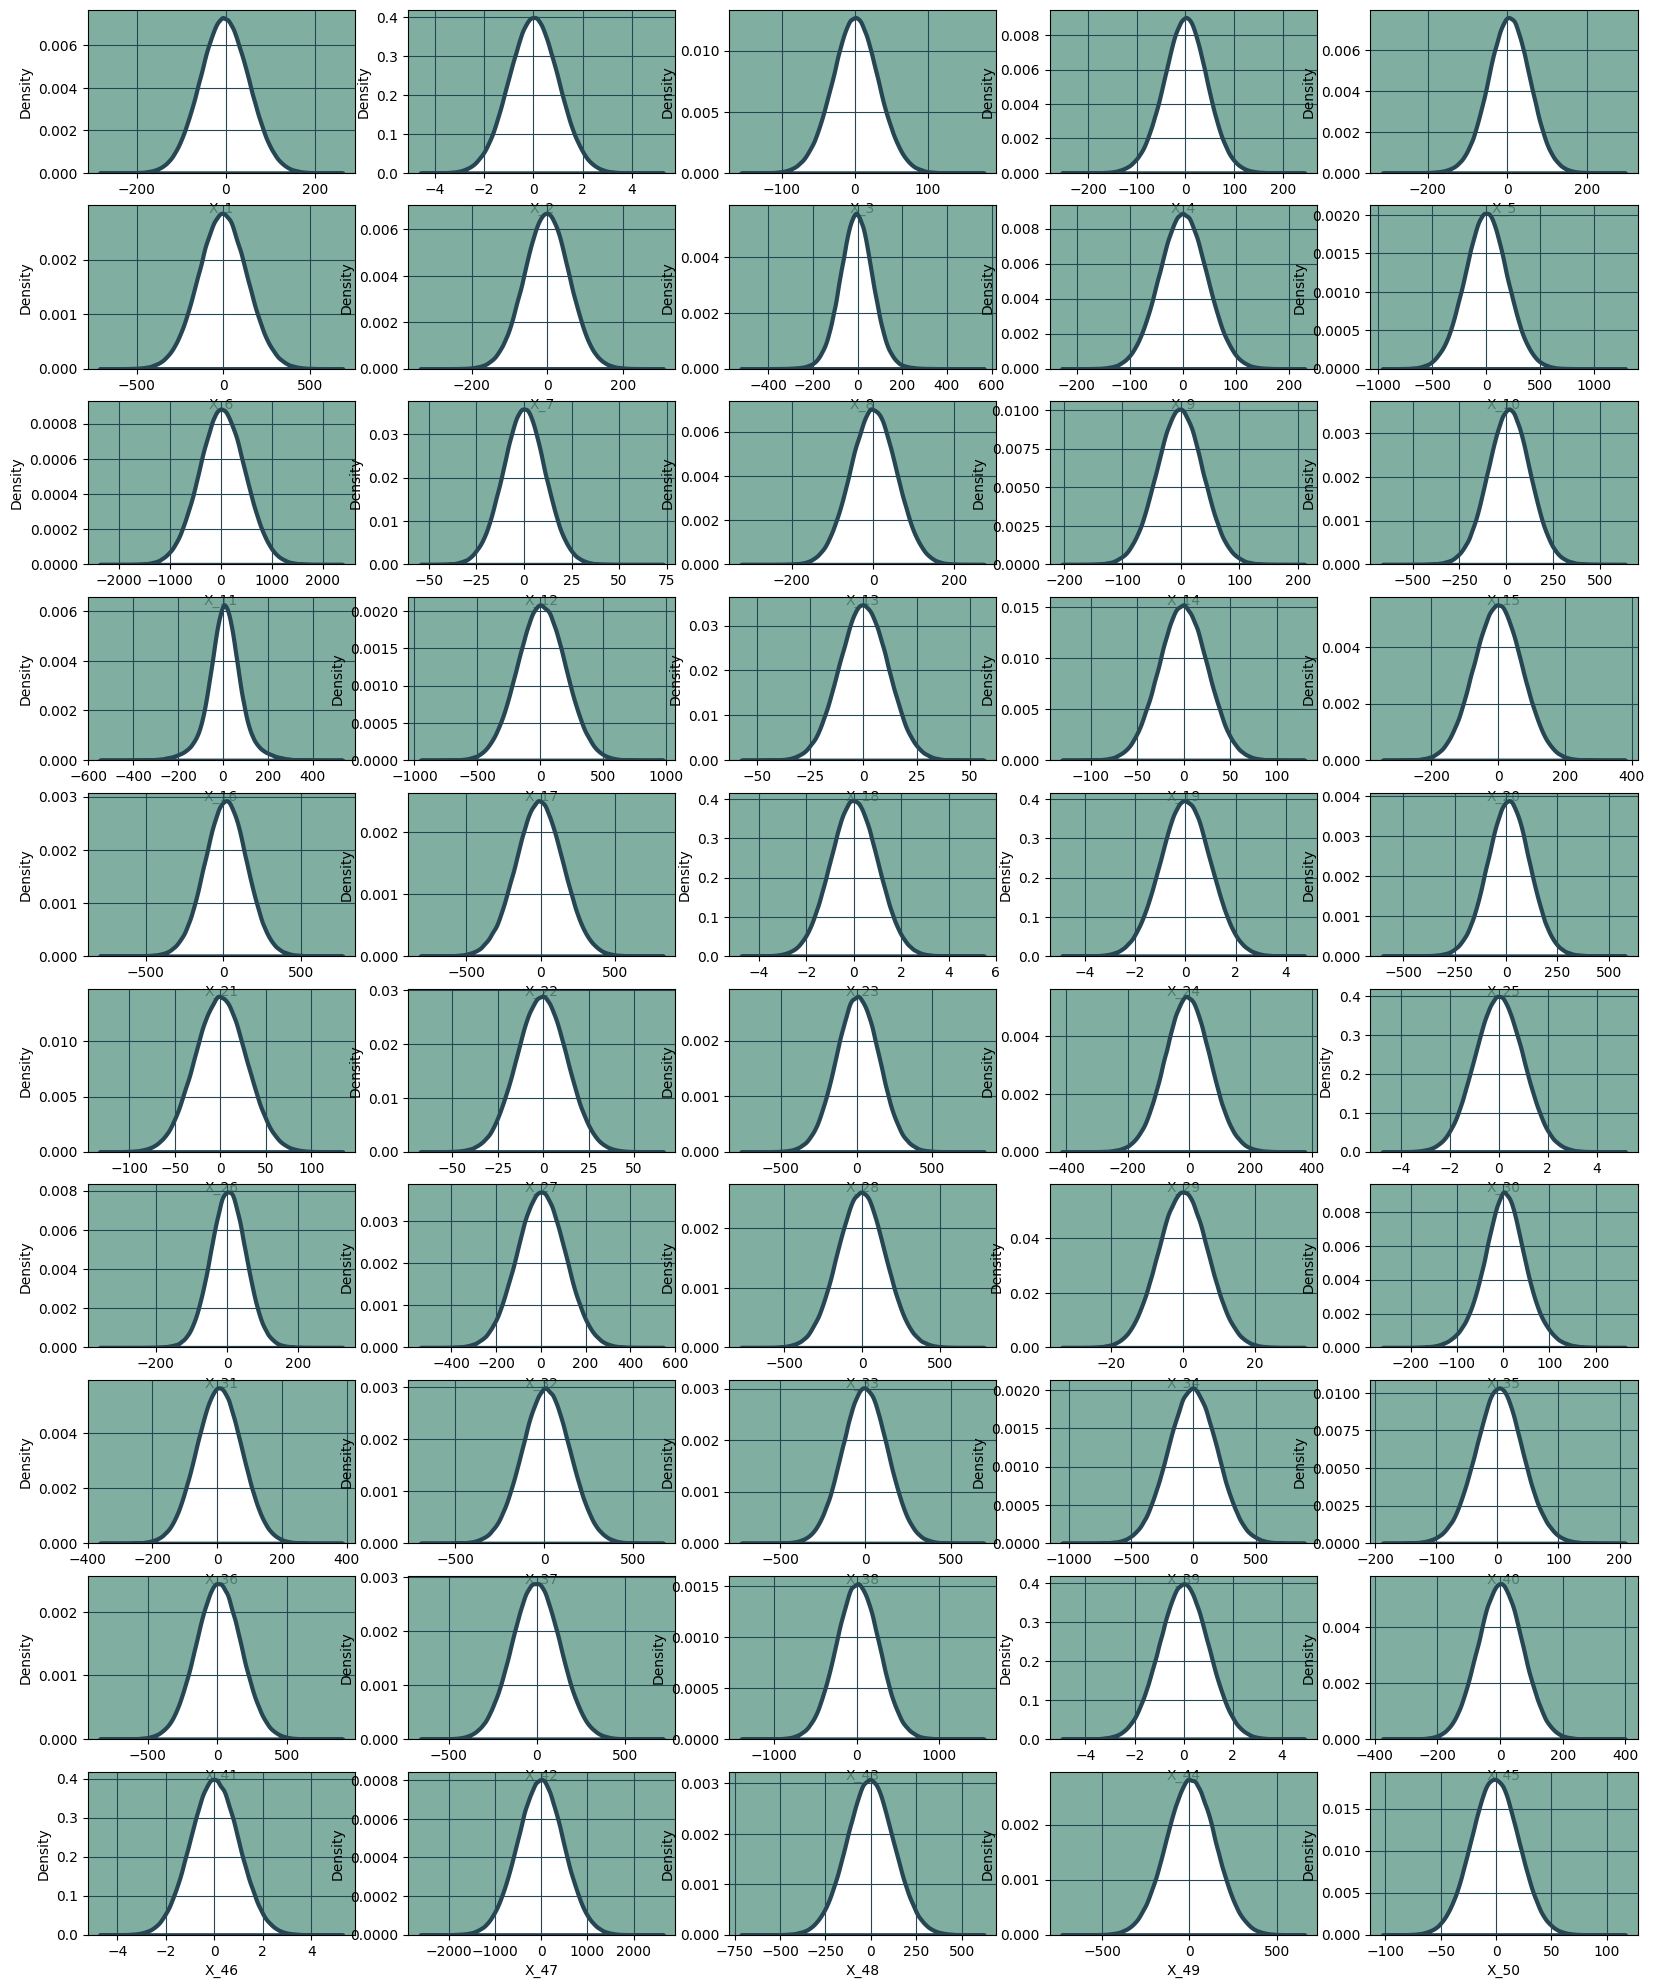

In [9]:

rows, cols = 10, 5

f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))

f.set_facecolor("#fff")

n_feat = 1

for row in tqdm(range(rows)):
    for col in range(cols):
        try:
            sns.kdeplot(x=f'X_{n_feat}', fill=True, alpha=1, linewidth=3,
                        edgecolor="#264653", data=train, ax=axs[row, col], color='w')

            axs[row, col].patch.set_facecolor("#619b8a")
            axs[row, col].patch.set_alpha(0.8)

            axs[row, col].grid(color="#264653", alpha=1, axis="both")
        except IndexError:
            axs[row, col].set_visible(False)

        n_feat += 1


f.show()


  0%|          | 0/10 [00:00<?, ?it/s]

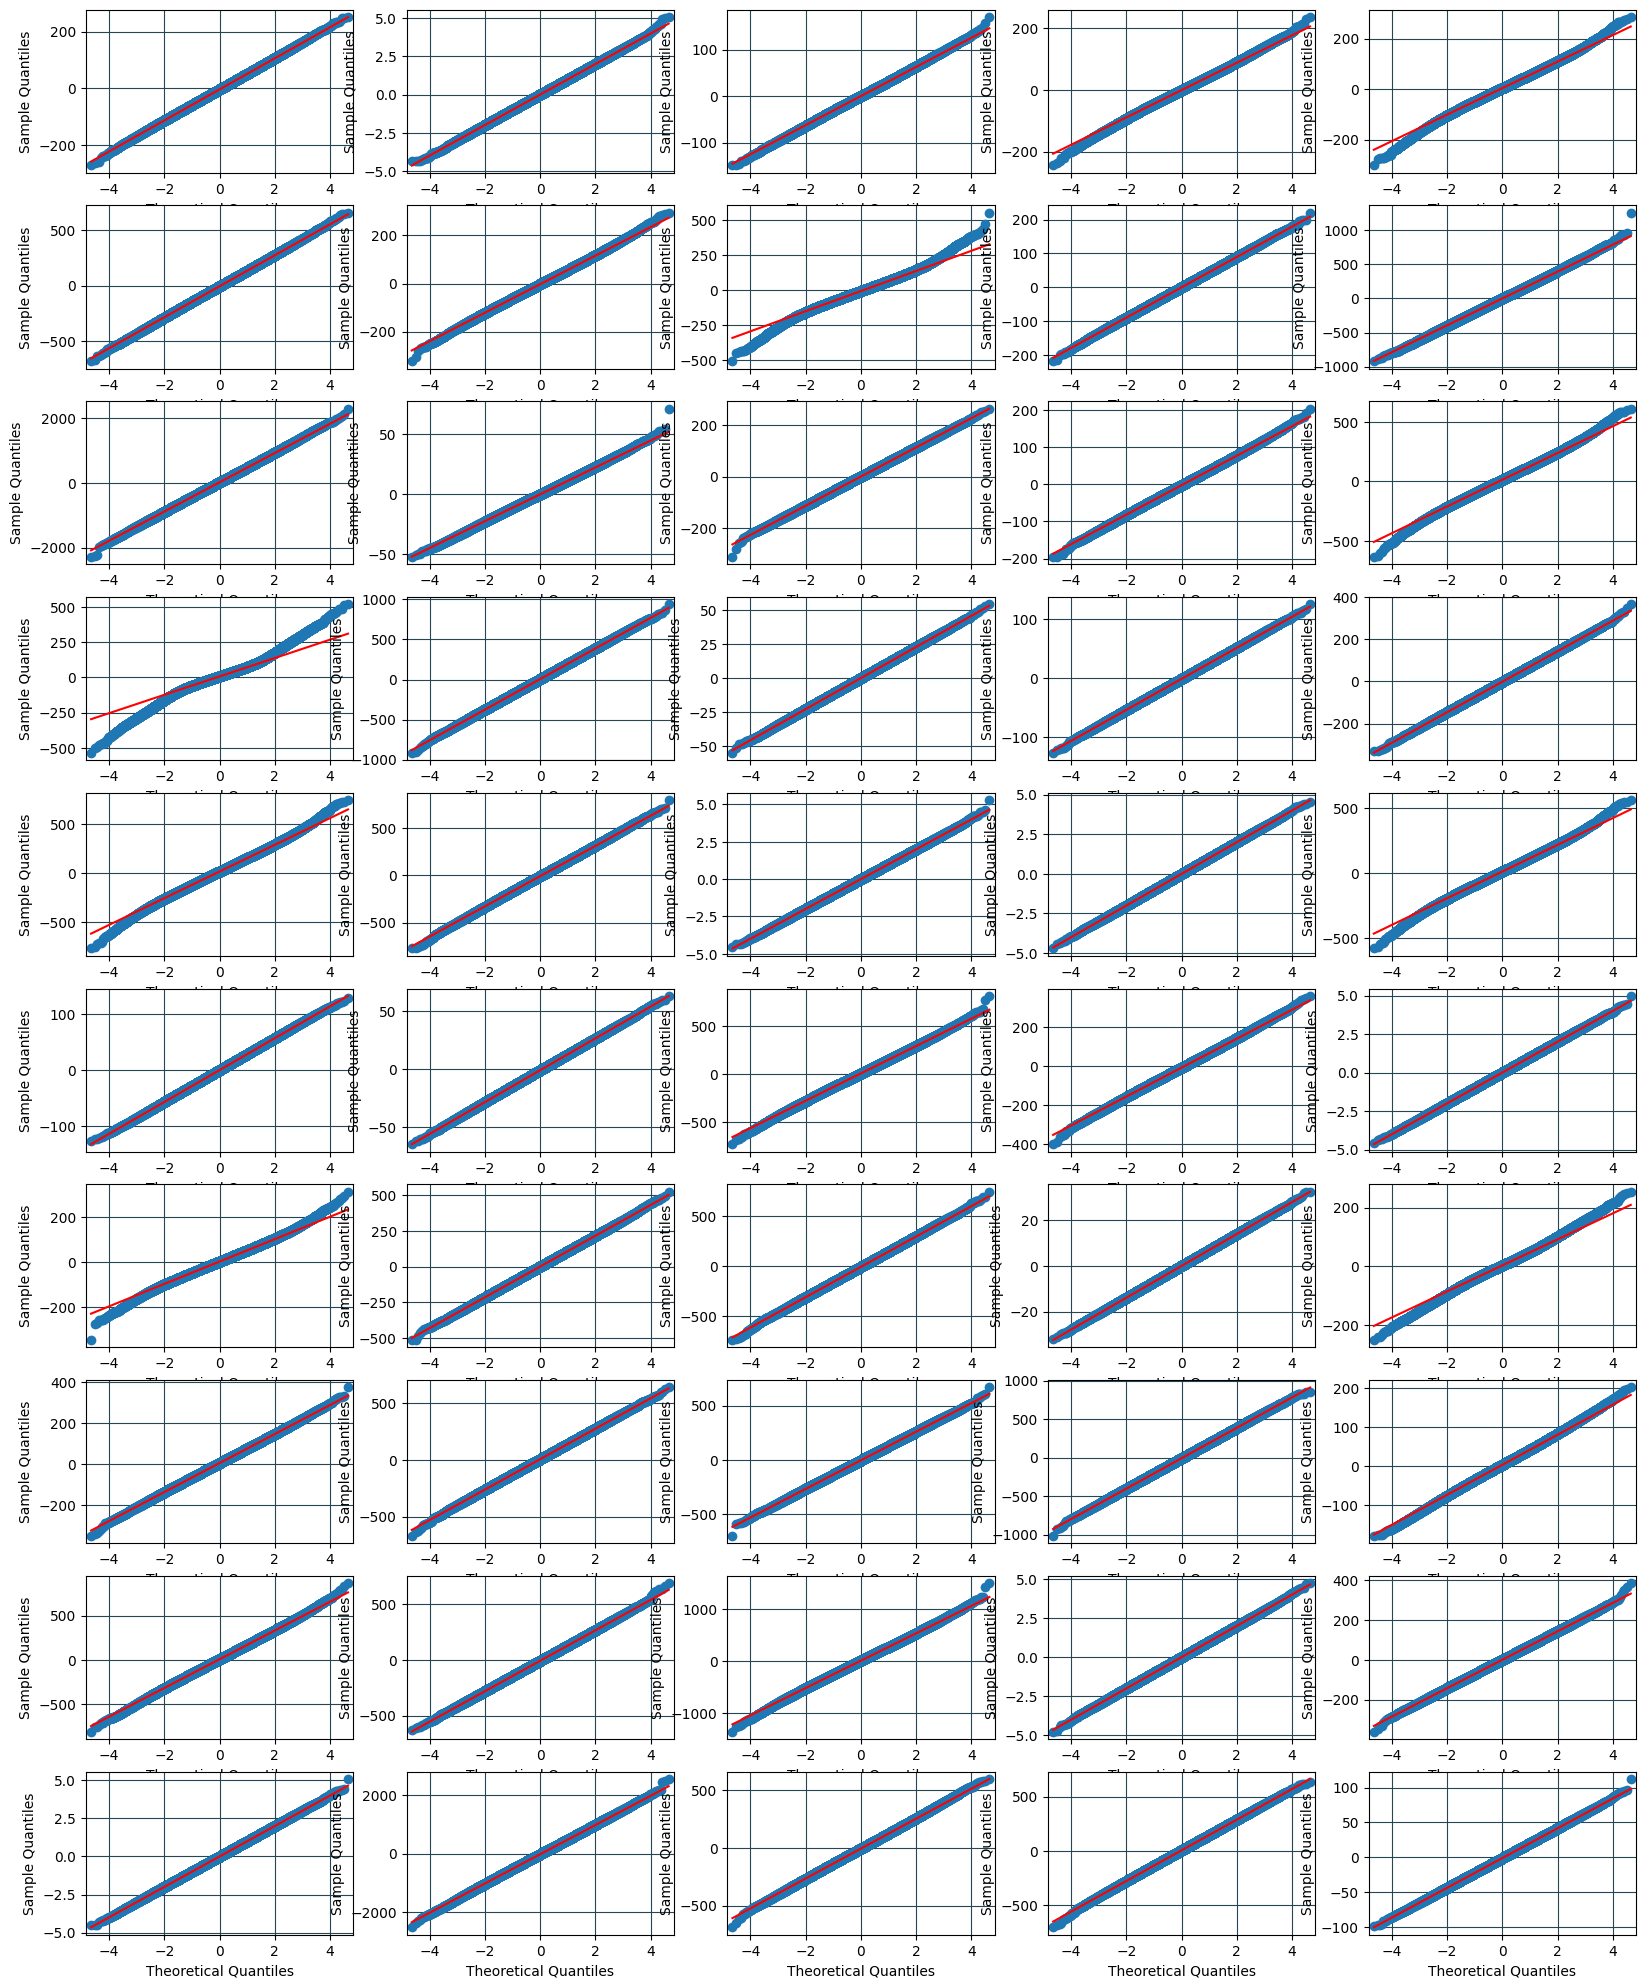

In [10]:
rows, cols = 10, 5

f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))

f.set_facecolor("#fff")

n_feat = 1

for row in tqdm(range(rows)):
    for col in range(cols):
        try:
            # sns.kdeplot(x=f'X_{n_feat}', fill=True, alpha=1, linewidth=3,
            #             edgecolor="#264653", data=train, ax=axs[row, col], color='w')

            qqplot(train[f'X_{n_feat}'], ax=axs[row, col], line='q')

            axs[row, col].grid(color="#264653", alpha=1, axis="both")

        except IndexError:
            axs[row, col].set_visible(False)

        n_feat += 1

f.show()


**Metrics**

In [11]:
train.columns


Index(['id', 'treatment_group', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6',
       'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
       'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24',
       'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33',
       'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42',
       'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50',
       'conversion'],
      dtype='object')

In [12]:
train['treatment_group'].unique()


array(['control', 'treatment'], dtype=object)

In [14]:
train['treatment_group'] = train['treatment_group'].apply(lambda x: 1 if x=='treatment' else 0)

In [15]:
from sklearn.model_selection import train_test_split

train = train[:100000]

X = train[[f'X_{i}' for i in range(1, 51)]]

treatment = train['treatment_group']

y = train['conversion']

X_train, X_val, y_train, y_val, treatment_train, treatment_val = train_test_split(X, y, treatment, test_size=0.2)


**S-Learner**

The main idea of S-learner is to train one model with features, binary treatment (W) and with binary target of action (Y). Then get the prediction for test data with constant W=1 and W=0. The difference is a uplift effect.



In [16]:
# define get_metrics，accept y_val, uplift, treatment_val
def get_metrics(y_val, uplift, treatment_val):

    # top 30%
    upliftk = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treatment_val, strategy='by_group', k=0.3)
    upliftk_all = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treatment_val, strategy='overall', k=0.3)

    # Qini
    qini_coef = qini_auc_score(y_true=y_val, uplift=uplift, treatment=treatment_val)


    # auc
    uplift_auc = uplift_auc_score(y_true=y_val, uplift=uplift, treatment=treatment_val)
    # average
    wau = weighted_average_uplift(y_true=y_val, uplift=uplift, treatment=treatment_val, strategy='by_group')
    wau_all = weighted_average_uplift(y_true=y_val, uplift=uplift, treatment=treatment_val)


    print(f'uplift at top 30% by group: {upliftk:.2f} by overall: {upliftk_all:.2f}\n',
          f'Weighted average uplift by group: {wau:.2f} by overall: {wau_all:.2f}\n',
          f'AUUC by group: {uplift_auc:.2f}\n',
          f'AUQC by group: {qini_coef:.2f}\n')

    return {'uplift@30': upliftk, 'uplift@30_all': upliftk_all, 'AUQC': qini_coef, 'AUUC': uplift_auc,
            'WAU': wau, 'WAU_all': wau_all}


In [17]:
# XGBoost classifer model
xgb_sm = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)

# SoloModel
sm = SoloModel(estimator=xgb_sm)

# fit model SoloModel
sm = sm.fit(X_train, y_train, treatment_train, estimator_fit_params={})

# use fitted model
uplift_sm = sm.predict(X_val)

# evaluation
res = get_metrics(y_val, uplift_sm, treatment_val)


uplift at top 30% by group: 0.20 by overall: 0.20
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.15
 AUQC by group: 0.21



***T - learner ***

The main idea of T-learner is to train two independent models: one based on observations after treatment (T), another one on control rows (C). The uplift effect is the difference between predictions on data from model T and model C.



In [18]:
xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)

sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C)

sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)

res = get_metrics(y_val, uplift_sm, treatment_val)


uplift at top 30% by group: 0.19 by overall: 0.19
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.13
 AUQC by group: 0.19



**T-Learner dependent models**

The main idea of T-learner with dependent models is to train T or C model using predictions (probs) from the opposite model. This approach has been adopted from classifier chain method: https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html

In [19]:

xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)

sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C, method='ddr_control')

sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)


res = get_metrics(y_val, uplift_sm, treatment_val)


uplift at top 30% by group: 0.19 by overall: 0.19
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.13
 AUQC by group: 0.19



In [20]:

xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)

sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C, method='ddr_treatment')


sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)

res = get_metrics(y_val, uplift_sm, treatment_val)


uplift at top 30% by group: 0.19 by overall: 0.19
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.13
 AUQC by group: 0.19

